## Autonomous_Mobile_Robotics Segmentation task 1
* Usage

Run the cell below first to initialize the libraries required and perform ground segmentation. 

(34720, 4)
(34720, 4)
Estimated number of clusters: 122
Estimated number of noise points: 148


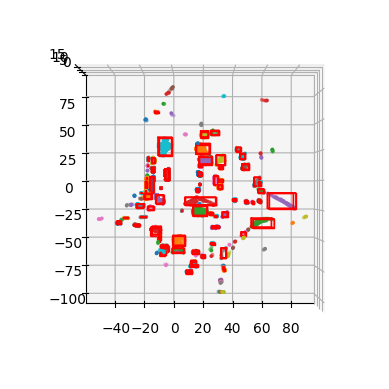

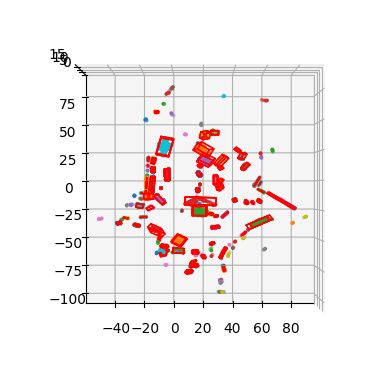

In [10]:
import os
import sys
import pathlib
import math
import random
import json
import numpy as np 
import open3d as o3d
import sklearn.cluster
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import art3d

def clustering(points, method):
    ''' Perform clustering to the points using the method given
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): the point cloud to be clustered
    `method` (`string`): the method used. Options: `'dbscan'`, `'kmeans'`, `'optics'`, `'meanshift'`, `'AgglomerativeClustering'`, `'birch'`

    Returns
    -------
    `labels` (`numpy.ndarray`): The labels of each point
    '''
    if method == 'dbscan':
        db = sklearn.cluster.DBSCAN(eps=2,min_samples=3).fit(points)#eps=1.8, min_samples=20
        labels_db = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise_ = list(labels_db).count(-1)
        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)
        return labels_db

    if method == 'kmeans':
        kmeans = sklearn.cluster.KMeans(n_clusters=70, random_state=0, n_init="auto").fit(points)
        labels_km = kmeans.labels_
        return labels_km

    if method == 'meanshift':
        # The following bandwidth can be automatically detected using
        bandwidth = sklearn.cluster.estimate_bandwidth(points, quantile=0.1, n_samples=500)

        ms = sklearn.cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(points)
        labels_ms = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(labels_ms)
        n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)
        return labels_ms

    if method == 'optics':
        clust = sklearn.cluster.OPTICS(min_samples=6)

        # Run the fit
        clust.fit(points)
        labels_op = clust.labels_[clust.ordering_]
        return labels_op

    if method == 'AgglomerativeClustering':
        clustering = sklearn.cluster.AgglomerativeClustering(70).fit(points)
        return clustering.labels_

    if method == 'birch':
        brc = sklearn.cluster.Birch(n_clusters=None).fit(points)
        labels_brc = brc.predict(points)
        return labels_brc

def ExtractBBox(points,labels,method):
    if method == 'oriented':
        bboxes = []
        sortedLabels = np.unique(labels)
        for label in sortedLabels:
            cluster = []
            for i in range(len(labels)):
                if labels[i] == label:
                    cluster.append(points[i])
            if len(cluster) < 7:   #Noise removal
                continue
            cluster = np.array(cluster)
            cluster = o3d.utility.Vector3dVector(cluster)
            bbox = o3d.geometry.OrientedBoundingBox()
            bbox = bbox.create_from_points(cluster)
            bbox = np.asarray(bbox.get_box_points())
            bbox = np.array([bbox[3],bbox[6],bbox[1],bbox[0],bbox[5],bbox[4],bbox[7],bbox[2]])
            bboxes.append(bbox)
        bboxes = np.array(bboxes)
        return bboxes

    if method == 'axisAlighed':
        bboxes = []
        for label in np.unique(labels):
            cluster = points[label == labels,:]
            if len(cluster) < 7:   #Noise removal
                continue
            x_min, x_max = np.min(cluster[:, 0]), np.max(cluster[:, 0])
            y_min, y_max = np.min(cluster[:, 1]), np.max(cluster[:, 1])
            z_min, z_max = np.min(cluster[:, 2]), np.max(cluster[:, 2])
            bbox = np.array([[x_min,y_min,z_min],
                            [x_max,y_min,z_min],
                            [x_max,y_max,z_min],
                            [x_min,y_max,z_min],
                            [x_min,y_min,z_max],
                            [x_max,y_min,z_max],
                            [x_max,y_max,z_max],
                            [x_min,y_max,z_max]])
            bboxes.append(bbox)
        bboxes = np.array(bboxes)
        return bboxes

def vis(points,labels,bboxes,method):
    '''
    :param points: n*3 matrix
    :param labels: n*1 matrix
    :param methods: string
    :return: visualization
    '''
    if method == 'o3d':
        labels=np.asarray(labels)
        max_label=labels.max()

        # 颜色
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        pt1 = o3d.geometry.PointCloud()
        pt1.points = o3d.utility.Vector3dVector(points.reshape(-1, 3))
        pt1.colors=o3d.utility.Vector3dVector(colors[:, :3])

        o3d.visualization.draw_geometries([pt1],'part of cloud',width=500,height=500)
    if method == 'plt':
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for label in np.unique(labels):
            ax.scatter(points[:,0:3][label == labels, 0], 
                    points[:,0:3][label == labels, 1], 
                    points[:,0:3][label == labels, 2],
                    s = 3,
                    )
        for bbox in bboxes:
            verts = [[bbox[0],bbox[1],bbox[2],bbox[3]],
            [bbox[4],bbox[5],bbox[6],bbox[7]],
            [bbox[0],bbox[1],bbox[5],bbox[4]],
            [bbox[2],bbox[3],bbox[7],bbox[6]],
            [bbox[1],bbox[2],bbox[6],bbox[5]],
            [bbox[4],bbox[7],bbox[3],bbox[0]]]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=[0,0,0,0], linewidths=1, edgecolors='r'))
        ax.view_init(elev=90, azim=-90)
        plt.show()

def main():
    file_data = np.fromfile('/home/jidan/Documents/me5413/1_lidar/lidar_data/frame2.pcd.bin', dtype=np.float32)
    points = file_data.reshape((-1, 5))[:, :4]
    print(np.shape(points))
    # Points: (x, y, z, intensity)

    #Ground segmentation
    ground_cloud,segmented_cloud, index_ground, index_segmented = ground_segmentation(points[:,0:3],'brutal')
    x = points[:, 0]  # x position of point
    y = points[:, 1]  # y position of point
    z = points[:, 2]  # z position of point
    r = points[:, 3]  # reflectance value of point
    d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
    degr = np.degrees(np.arctan(z / d))
    # vals = 'height'
    # if vals == "height":
    #     col = z
    # else:
    #     col = dfile_data = np.fromfile('/home/jidan/Documents/me5413/1_lidar/lidar_data/frame2.pcd.bin', dtype=np.float32)
    points = file_data.reshape((-1, 5))[:, :4]
    print(np.shape(points))
    # Points: (x, y, z, intensity)

    #Ground segmentation
    ground_cloud,segmented_cloud, index_ground, index_segmented = ground_segmentation(points[:,0:3],'brutal')
    x = points[:, 0]  # x position of point
    y = points[:, 1]  # y position of point
    z = points[:, 2]  # z position of point
    r = points[:, 3]  # reflectance value of point
    d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
    degr = np.degrees(np.arctan(z / d))
    # vals = 'height'
    # if vals == "height":

    #Clustering
    method = 'dbscan'  #Options: 'dbscan','kmeans','optics','meanshift','AgglomerativeClustering', 'birch'
    labels = clustering(segmented_cloud, method)
    labels += 1
    #Add labels to the whole pointcloud
    points = np.insert(points,4,0,axis = 1)
    points[index_ground, 4] = 1
    points[index_segmented, 4] = labels
    #Add labels to the segmented pointcloud
    segmented_cloud = np.insert(segmented_cloud,3,0,axis = 1)
    segmented_cloud[:,3] = labels
    #Noise removal
    points = points[points[:,4] > 0]
    segmented_cloud = segmented_cloud[segmented_cloud[:,3] > 0]

    #Bounding Box Extraction
    axis_aligned_bboxes = ExtractBBox(segmented_cloud[:,0:3], segmented_cloud[:,3],'axisAlighed')
    oriented_bboxes = ExtractBBox(segmented_cloud[:,0:3], segmented_cloud[:,3],'oriented')

    #Visualization
    vis(points[:,0:3],points[:,4],axis_aligned_bboxes,method='o3d')#With ground points
    vis(segmented_cloud[:,0:3],segmented_cloud[:,3],axis_aligned_bboxes,method='o3d')#Without ground points
    vis(segmented_cloud[:,0:3],segmented_cloud[:,3],axis_aligned_bboxes,method='plt')#With axis aligned bounding boxes
    vis(segmented_cloud[:,0:3],segmented_cloud[:,3],oriented_bboxes,method='plt')#With oriented bounding boxes

    #Data saving

if __name__ == '__main__':
    main()